<a href="https://colab.research.google.com/github/Arrizky0911/computer-vision-learning/blob/main/Respiratory_Diseases_Multiclass_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup Environment**





## Import necessary library

In [1]:
!pip install kaggle

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from keras.preprocessing import image
import zipfile
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Import kaggle vehicles dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Mounted at /content/drive


In [4]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
License(s): CC-BY-SA-4.0
 92% 145M/158M [00:01<00:00, 124MB/s]
100% 158M/158M [00:01<00:00, 121MB/s]


In [5]:
file_path = '/content/covid19-image-dataset.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')

#**Setup Dataset**

In [6]:
image_gen_train = ImageDataGenerator(
                    validation_split=0.2
                    )

In [7]:
train_generator = image_gen_train.flow_from_directory(
    '/content/drive/MyDrive/kaggle/Covid19-dataset/train',
    target_size=(100, 150),
    batch_size = 32,
    shuffle=True,
)

validation_generator = image_gen_train.flow_from_directory(
    '/content/drive/MyDrive/kaggle/Covid19-dataset/test',
    target_size=(100, 150),
    batch_size = 32,
    shuffle=True,
)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


visualize the result

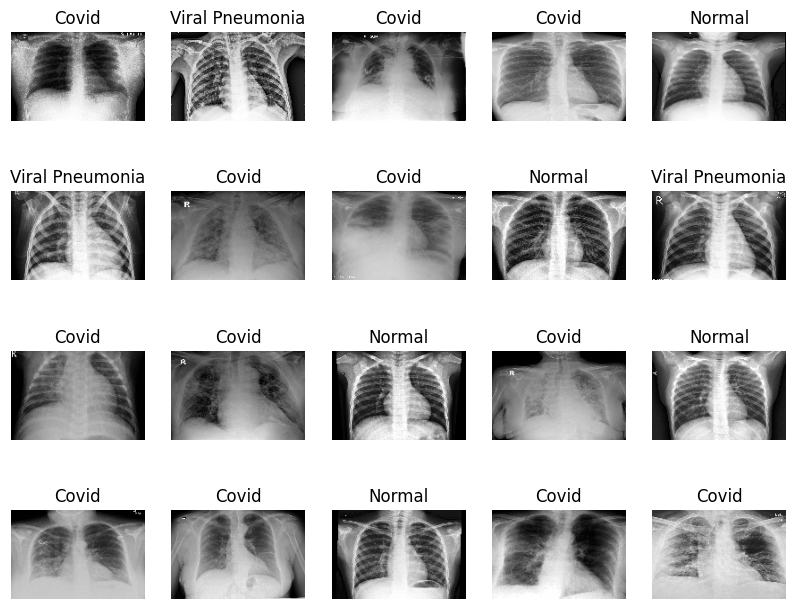

In [8]:
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
  for i in range(20):  # Plot the first 20 images in the batch
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(images[i].astype("uint8"))

      true_class_index = np.argmax(labels[i])
      plt.title(class_names[true_class_index])

      plt.axis("off")
  break  # Stop after plotting the first batch
plt.show()

# **Image Classification Model**

## **Setup training variables**

In [9]:
lr = 1e-3 # common choice for learning rate
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr) # adam optimizer with generalization
loss = tf.keras.losses.CategoricalCrossentropy() # very common loss function for multiclass classification problem

EPOCH = 25 # a common epoch choice for image classification
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

strategy = tf.distribute.get_strategy() # accelerate the training

In [10]:
def plot_history(history):
  #summarize history for training
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## **Common CNN Model**

This model applying a common CNN architectures for image classification.

In [11]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(100, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 148, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 17, 128)       0

Train cnn model

In [12]:
with strategy.scope():
  cnn_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  cnn_history = cnn_model.fit(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN,
      validation_data=validation_generator,
      validation_steps=STEP_SIZE_VALID,
      epochs=EPOCH
  )

  cnn_scores = cnn_model.evaluate(validation_generator,
                            steps=STEP_SIZE_VALID)

Epoch 1/25
7/7 [==============================] - 8s 977ms/step - loss: 223.3602 - accuracy: 0.4566 - val_loss: 3.2988 - val_accuracy: 0.7031
Epoch 2/25
7/7 [==============================] - 6s 876ms/step - loss: 4.8040 - accuracy: 0.6256 - val_loss: 2.8218 - val_accuracy: 0.5781
Epoch 3/25
7/7 [==============================] - 6s 893ms/step - loss: 0.6391 - accuracy: 0.8265 - val_loss: 0.5328 - val_accuracy: 0.8125
Epoch 4/25
7/7 [==============================] - 6s 805ms/step - loss: 0.3320 - accuracy: 0.8950 - val_loss: 0.3965 - val_accuracy: 0.8125
Epoch 5/25
7/7 [==============================] - 6s 853ms/step - loss: 0.1795 - accuracy: 0.9269 - val_loss: 0.4290 - val_accuracy: 0.7812
Epoch 6/25
7/7 [==============================] - 6s 843ms/step - loss: 0.1192 - accuracy: 0.9452 - val_loss: 0.2759 - val_accuracy: 0.8750
Epoch 7/25
7/7 [==============================] - 6s 909ms/step - loss: 0.0591 - accuracy: 0.9863 - val_loss: 0.2585 - val_accuracy: 0.9062
Epoch 8/25
7/7 [==

In [13]:
print('Test loss:', cnn_scores[0])
print('Test accuracy:', cnn_scores[1])

Test loss: 0.20837152004241943
Test accuracy: 0.890625


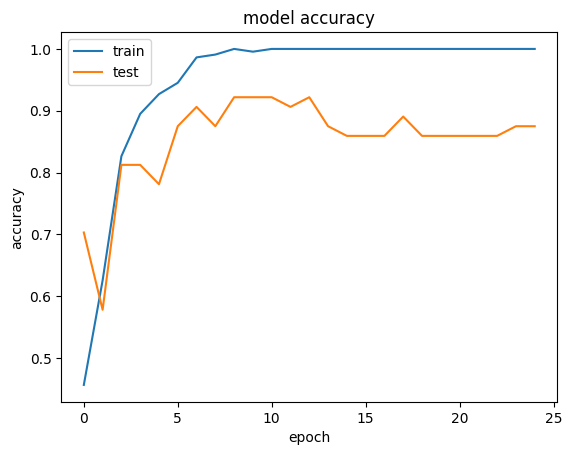

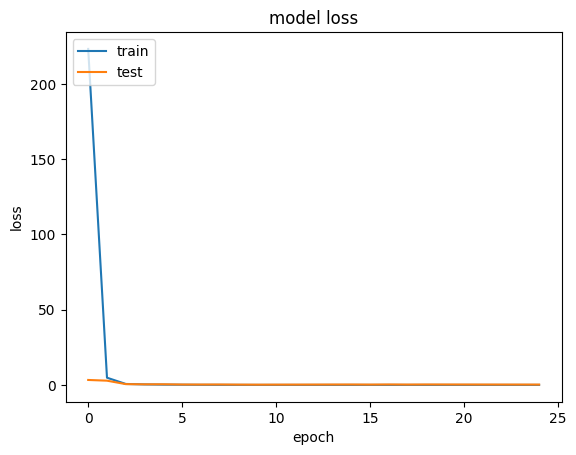

In [14]:
plot_history(cnn_history)

Save the model

In [15]:
cnn_model.save('/content/drive/MyDrive/kaggle/cnnCovid.keras')

## **AlexNet Model**

This is implementation of AlexNet, an 8 layer neural network architecture

In [16]:
alexnet_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), strides=(4,4), input_shape=(100,150,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

print(alexnet_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 25, 37, 96)        2688      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 18, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 18, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 9, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 9, 384)         885120    
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 9, 384)        

Train alexnet

In [17]:
with strategy.scope():
  # I don't know why I can't use AdamW on alexNet
  alexnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])
  alexnet_history = alexnet_model.fit(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN,
      validation_data=validation_generator,
      validation_steps=STEP_SIZE_VALID,
      epochs=EPOCH
  )

  alexnet_scores = alexnet_model.evaluate(validation_generator,
                            steps=STEP_SIZE_VALID)


Epoch 1/25
7/7 [==============================] - 8s 1s/step - loss: 205.8333 - accuracy: 0.3059 - val_loss: 2.1478 - val_accuracy: 0.3750
Epoch 2/25
7/7 [==============================] - 6s 893ms/step - loss: 1.1497 - accuracy: 0.4977 - val_loss: 0.9293 - val_accuracy: 0.5312
Epoch 3/25
7/7 [==============================] - 6s 941ms/step - loss: 0.8999 - accuracy: 0.5890 - val_loss: 0.6916 - val_accuracy: 0.6875
Epoch 4/25
7/7 [==============================] - 6s 888ms/step - loss: 0.6843 - accuracy: 0.6875 - val_loss: 1.0225 - val_accuracy: 0.4375
Epoch 5/25
7/7 [==============================] - 6s 906ms/step - loss: 0.5729 - accuracy: 0.7545 - val_loss: 0.8021 - val_accuracy: 0.6875
Epoch 6/25
7/7 [==============================] - 6s 949ms/step - loss: 0.4393 - accuracy: 0.8311 - val_loss: 0.4375 - val_accuracy: 0.7344
Epoch 7/25
7/7 [==============================] - 6s 929ms/step - loss: 0.3377 - accuracy: 0.8813 - val_loss: 0.7769 - val_accuracy: 0.6875
Epoch 8/25
7/7 [=====

In [18]:
print('Test loss:', alexnet_scores[0])
print('Test accuracy:', alexnet_scores[1])

Test loss: 0.6365891098976135
Test accuracy: 0.828125


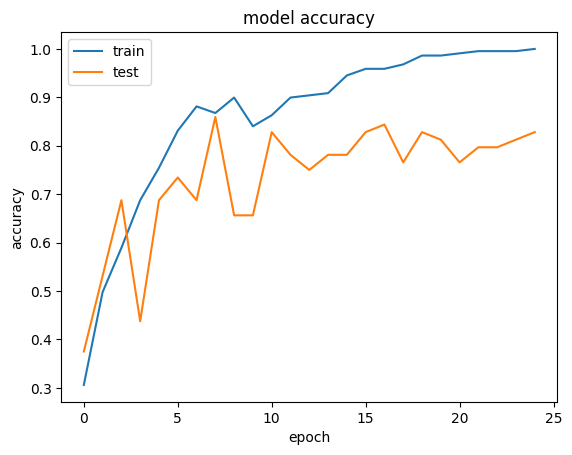

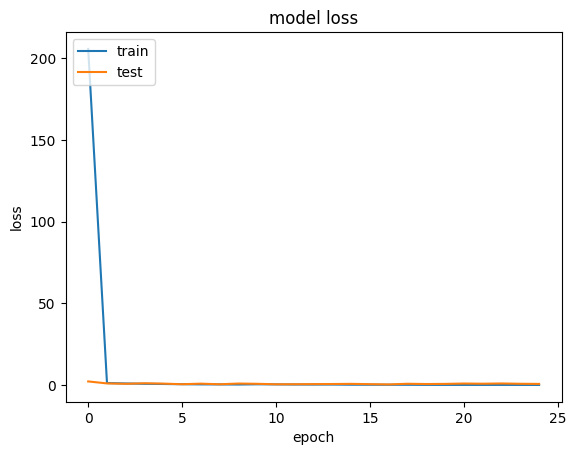

In [19]:
plot_history(alexnet_history)

Save alexnet model

In [20]:
alexnet_model.save('/content/drive/MyDrive/kaggle/alexNetCovid.keras')

## **GoogleNet Model**

**Inception Block**

Inception block is a special block implemented in googlenet. It has four paths parallel paths from the input. The first path only consists 1x1 convolutional layer. The middle two paths consists of two different convolutional layer, which each of those performs 1x1 convolutional layer in the input, then followed by 3x3 for the 2nd path and 5x5 for the third path. The last path first performs 3x3 maximum pooling layer, then followed by 1x1 convolutional layer.Finally, the outputs along each path are concatenated along the channel dimension and comprise the block's output.



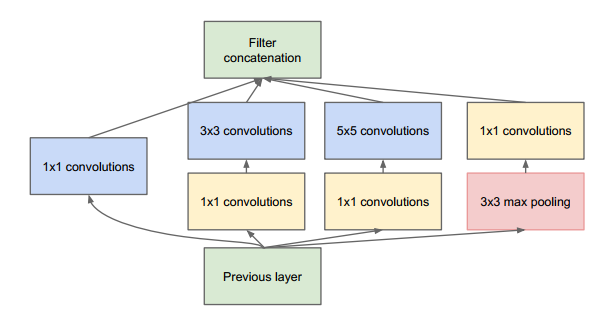

In [21]:
class Inception(tf.keras.Model):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')

        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same', activation='relu')

        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same', activation='relu')

        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.p4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')


    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        return tf.keras.layers.Concatenate()([p1, p2, p3, p4])

The following are the googleNet architecture.

inception-full.svg

In [27]:
googlenet_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), input_shape=(100,150,3),  activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), activation='relu'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),
    Inception(64, (96, 128), (16, 32), 32),
    Inception(128, (128, 192), (32, 96), 64),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),
    Inception(192, (96, 208), (16, 48), 64),
    Inception(160, (112, 224), (24, 64), 64),
    Inception(128, (128, 256), (24, 64), 64),
    Inception(112, (144, 288), (32, 64), 64),
    Inception(256, (160, 320), (32, 128), 128),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),
    Inception(256, (160, 320), (32, 128), 128),
    Inception(384, (192, 384), (48, 128), 128),
    tf.keras.layers.GlobalAvgPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])

print(googlenet_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 47, 72, 64)        9472      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 24, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_66 (Conv2D)          (None, 24, 36, 64)        4160      
                                                                 
 conv2d_67 (Conv2D)          (None, 24, 36, 192)       110784    
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 12, 18, 192)       0         
 ng2D)                                                           
                                                                 
 inception_9 (Inception)     (None, 12, 18, 256)      

Train googlenet model

In [29]:
with strategy.scope():
  googlenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])

  googlenet_history = googlenet_model.fit(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN,
      validation_data=validation_generator,
      validation_steps=STEP_SIZE_VALID,
      epochs=EPOCH
  )

  googlenet_scores = googlenet_model.evaluate(validation_generator,
                            steps=STEP_SIZE_VALID)

Epoch 1/25
7/7 [==============================] - 15s 1s/step - loss: 2.6054 - accuracy: 0.3699 - val_loss: 1.1403 - val_accuracy: 0.3750
Epoch 2/25
7/7 [==============================] - 6s 939ms/step - loss: 1.0941 - accuracy: 0.3881 - val_loss: 1.0854 - val_accuracy: 0.4062
Epoch 3/25
7/7 [==============================] - 6s 910ms/step - loss: 1.0760 - accuracy: 0.4475 - val_loss: 1.1549 - val_accuracy: 0.3906
Epoch 4/25
7/7 [==============================] - 6s 945ms/step - loss: 1.0696 - accuracy: 0.4286 - val_loss: 1.0562 - val_accuracy: 0.3906
Epoch 5/25
7/7 [==============================] - 6s 853ms/step - loss: 0.9545 - accuracy: 0.4658 - val_loss: 0.8293 - val_accuracy: 0.6250
Epoch 6/25
7/7 [==============================] - 6s 881ms/step - loss: 0.8077 - accuracy: 0.6210 - val_loss: 0.8410 - val_accuracy: 0.6562
Epoch 7/25
7/7 [==============================] - 6s 889ms/step - loss: 0.9524 - accuracy: 0.4732 - val_loss: 1.1178 - val_accuracy: 0.2969
Epoch 8/25
7/7 [======

In [30]:
print('Test loss:', cnn_scores[0])
print('Test accuracy:', cnn_scores[1])

Test loss: 0.20837152004241943
Test accuracy: 0.890625


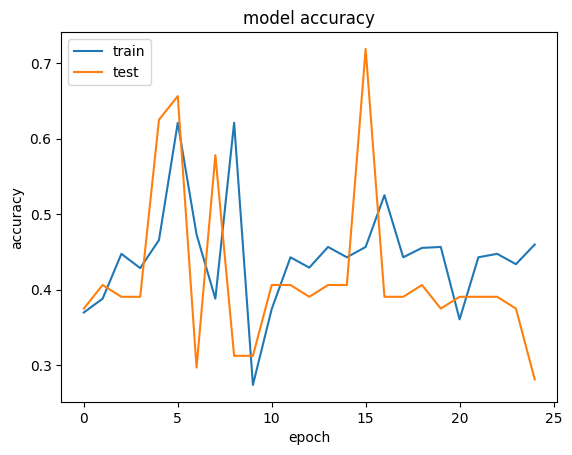

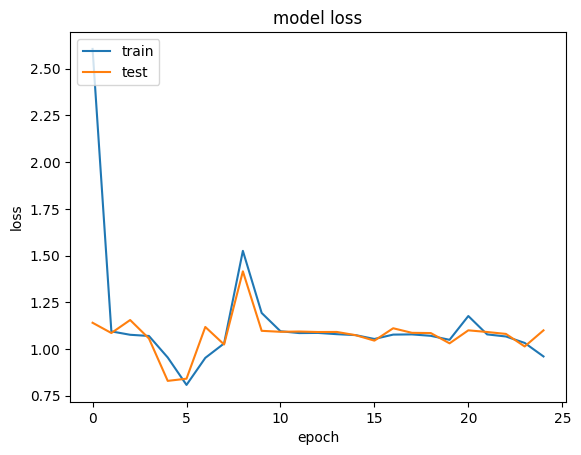

In [31]:
plot_history(googlenet_history)

Save googlenet model

In [32]:
googlenet_model.save('/content/drive/MyDrive/kaggle/googlenetCovid.keras')

## **MobileNet Model**

Load pre-trained mobilenetv2 model

In [33]:
mobilenetPreTrained = tf.keras.applications.MobileNetV2(input_shape=(100,150,3),
                                              include_top=False, # not inclued the FC and Classification layer
                                              weights='imagenet')

mobilenetPreTrained.trainable = False # Freeze all weight and parameter

9406464/9406464 [==============================] - 0s 0us/step


In [34]:
mobilenet_model = tf.keras.Sequential([
  mobilenetPreTrained,
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(3, activation='softmax')
])

print(mobilenet_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_122 (Conv2D)         (None, 2, 3, 32)          368672    
                                                                 
 dropout_2 (Dropout)         (None, 2, 3, 32)          0         
                                                                 
 global_average_pooling2d_2  (None, 32)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2626755 (10.02 MB)
Trainable params: 368

Train mobilenet model

In [36]:
with strategy.scope():
  mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])

  mobilenet_history = mobilenet_model.fit(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN,
      validation_data=validation_generator,
      validation_steps=STEP_SIZE_VALID,
      epochs=EPOCH
  )

  mobilenet_scores = mobilenet_model.evaluate(validation_generator,
                            steps=STEP_SIZE_VALID)

Epoch 1/25
7/7 [==============================] - 10s 1s/step - loss: 2.9483 - accuracy: 0.4475 - val_loss: 1.0434 - val_accuracy: 0.3906
Epoch 2/25
7/7 [==============================] - 6s 787ms/step - loss: 0.9932 - accuracy: 0.5799 - val_loss: 1.0582 - val_accuracy: 0.5781
Epoch 3/25
7/7 [==============================] - 6s 854ms/step - loss: 1.0198 - accuracy: 0.6347 - val_loss: 0.9402 - val_accuracy: 0.5156
Epoch 4/25
7/7 [==============================] - 6s 766ms/step - loss: 0.9303 - accuracy: 0.4509 - val_loss: 0.8591 - val_accuracy: 0.4219
Epoch 5/25
7/7 [==============================] - 6s 828ms/step - loss: 0.8429 - accuracy: 0.5160 - val_loss: 0.8459 - val_accuracy: 0.5000
Epoch 6/25
7/7 [==============================] - 6s 860ms/step - loss: 0.8237 - accuracy: 0.5616 - val_loss: 0.8142 - val_accuracy: 0.5156
Epoch 7/25
7/7 [==============================] - 6s 859ms/step - loss: 0.7805 - accuracy: 0.6027 - val_loss: 0.8361 - val_accuracy: 0.4844
Epoch 8/25
7/7 [======

In [37]:
print('Test loss:', mobilenet_scores[0])
print('Test accuracy:', mobilenet_scores[1])

Test loss: 0.6785792708396912
Test accuracy: 0.578125


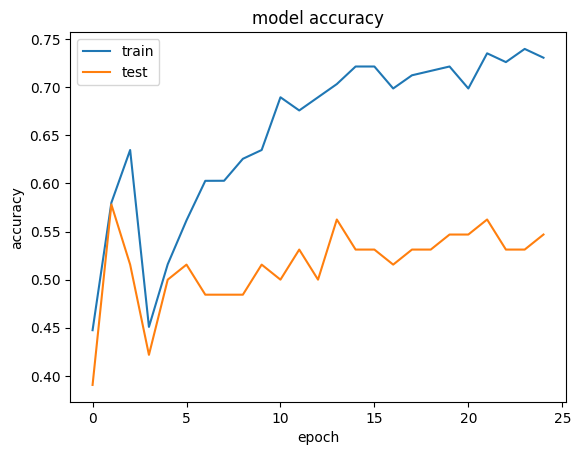

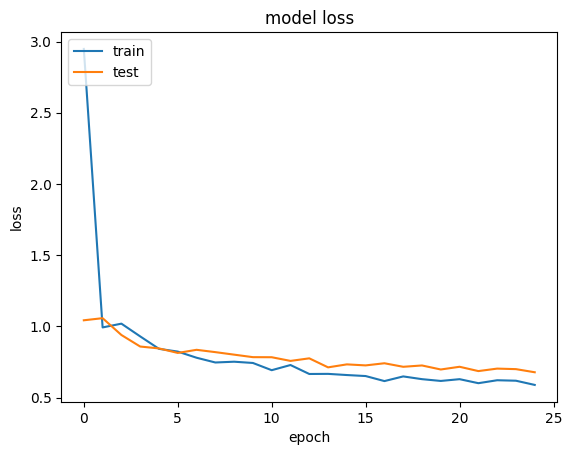

In [38]:
plot_history(mobilenet_history)

Save mobilenet model

In [39]:
googlenet_model.save('/content/drive/MyDrive/kaggle/mobilenetCovid.keras')